In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mnistDatasetLoader import MnistDatasetLoader
from mnistGan import MnistGan
from mnistCnn import MnistCnn

In [2]:
dataset = MnistDatasetLoader().loadDataset(batchSize = 256)
gan = MnistGan()
gan.loadWeights("MnistGanTEST/mnist_gen", "MnistGanTEST/mnist_disc")
cnn = MnistCnn()
cnn.loadWeights("MnistCnnTEST")

In [9]:
@tf.function
def g(x, index, classifier, discriminator):
    res = discriminator(x) - tf.math.log(tf.squeeze(classifier(x))[index])
    return res

def explainer(x, classifier, discriminator, maxIter, maxChange, minAlpha):
    epsilon = 1e-16
    closeEnough = False
    iter = 0
    index = tf.argmax(tf.squeeze(classifier(x))).numpy()
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            gRes = g(x, index, classifier, discriminator)
        grad = tape.gradient(gRes, x)
        maxGrad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(minAlpha, maxChange/tf.maximum(maxGrad, epsilon))
        x.assign(x + alpha * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if ((newIndex != index) and (discriminator(x).numpy() > 0)): # done when the prediction has changed
            closeEnough = True
    print("done after ", iter, " steps")

(1, 28, 28, 1)
[1.73384224e-11 1.49250390e-14 3.64776742e-09 1.08060408e-06
 2.97395076e-04 4.57813609e-09 1.30330546e-14 1.19808165e-05
 3.24986217e-06 9.99686360e-01]
[[2.8346186]]
done after  410  steps


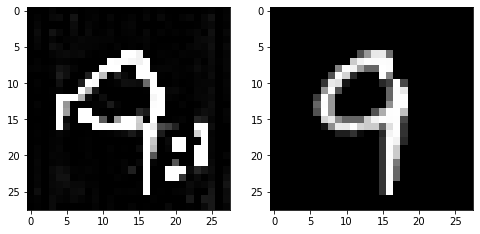

In [26]:
realImg = np.expand_dims(dataset.as_numpy_iterator().next()[0][0], 0)
x_ = tf.cast(realImg, tf.float32)
x = tf.Variable(x_)
print(x.shape)
origY = cnn.predict(x).numpy().squeeze()
origP = gan.discriminator(x).numpy()
print(origY)
print(origP)

explainer(x, cnn.model, gan.discriminator, maxIter = 600, maxChange = 0.099, minAlpha = 1000000)

_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x[0], cmap = 'gray')
ax[1].imshow(realImg[0], cmap = 'gray')

In [27]:
print(cnn.predict(x).numpy().squeeze())

[4.3977598e-14 1.3561437e-13 3.4643563e-05 5.1465909e-06 5.4682118e-01
 1.7264831e-10 3.6398159e-12 3.6979537e-04 2.1171947e-04 4.5255747e-01]
